# Finetuning via REINFORCE algorithm

## 1. Import libraries

In [1]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import coma
print(coma.__version__)

2.0.0


In [3]:
from coma.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from coma.vae import SmilesAutoencoder, RewardFunction
from coma.properties import qed, penalized_logp, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "qed"
SCORING_PROPERTY_FT = qed
threshold_property = 0.75
threshold_similarity = 0.3

#PROPERTY_NAME = "logp04"
#SCORING_PROPERTY_FT = penalized_logp
#threshold_property = 0.
#threshold_similarity = 0.3

#PROPERTY_NAME = "logp06"
#SCORING_PROPERTY_FT = penalized_logp
#threshold_property = 0.
#threshold_similarity = 0.5

In [6]:
SCORING_TANIMOTO_FT = similarity

## 4. Describe file information for inputs

In [7]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "data", PROPERTY_NAME))
input_ckpt_dir = f"outputs_1_pretraining_{PROPERTY_NAME}"

In [8]:
filepath_train             = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid             = os.path.join(input_data_dir, "rdkit_valid.txt")
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

## 5. Describe file information for outputs

In [9]:
output_dir = f"outputs_2_finetuning_{PROPERTY_NAME}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [10]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [11]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)

In [12]:
dataset.save_char2idx(filepath_char2idx)

In [13]:
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load the pretrained generator of COMA

In [14]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [15]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Start to train

In [16]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft, validation_dataset=dataset_valid,
                                                         batch_size=1000, total_steps=2000, learning_rate=1e-4,
                                                         discount_factor=0.995, buffer_size=2000, buffer_batch_size=50,
                                                         checkpoint_step=200, checkpoint_filepath=filepath_checkpoint,
                                                         display_step=100, verbose=1)

[000100/002000]  loss: 0.049  reward: 0.435  similarity: 0.576  property: 0.859  valid_ratio(va): 1.000  similarity(va): 0.372  property(va): 0.814  (27.3 min)
[000200/002000]  loss: 0.051  reward: 0.446  similarity: 0.516  property: 0.862  valid_ratio(va): 1.000  similarity(va): 0.356  property(va): 0.827  (51.6 min)
[000300/002000]  loss: 0.052  reward: 0.474  similarity: 0.510  property: 0.868  valid_ratio(va): 1.000  similarity(va): 0.346  property(va): 0.832  (76.1 min)
[000400/002000]  loss: 0.054  reward: 0.479  similarity: 0.478  property: 0.870  valid_ratio(va): 0.997  similarity(va): 0.340  property(va): 0.836  (100.4 min)
[000500/002000]  loss: 0.053  reward: 0.511  similarity: 0.501  property: 0.878  valid_ratio(va): 1.000  similarity(va): 0.336  property(va): 0.842  (124.9 min)
[000600/002000]  loss: 0.063  reward: 0.477  similarity: 0.479  property: 0.869  valid_ratio(va): 0.997  similarity(va): 0.325  property(va): 0.842  (149.9 min)
[000700/002000]  loss: 0.056  reward:

In [17]:
df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

## 10. Visualize for reward & loss analysis

In [18]:
sns.set_theme(style='whitegrid')

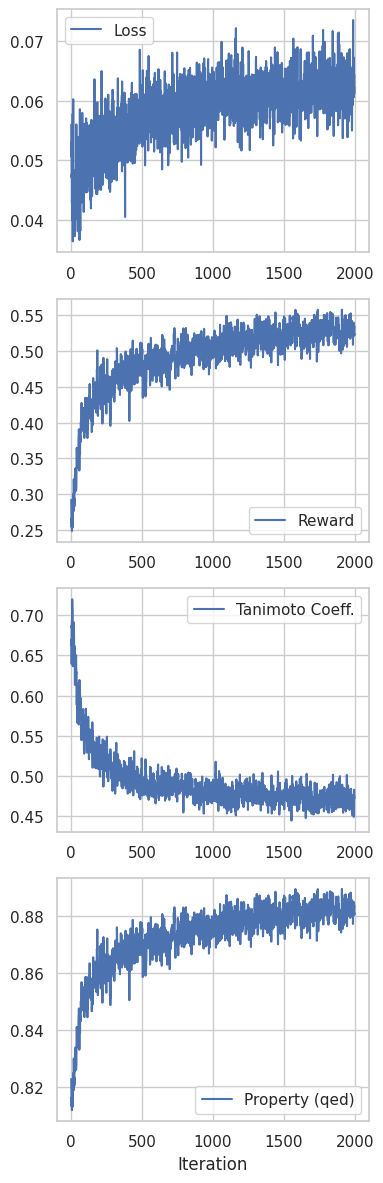

In [19]:
fig, axes = plt.subplots(4,1,figsize=(4,12))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

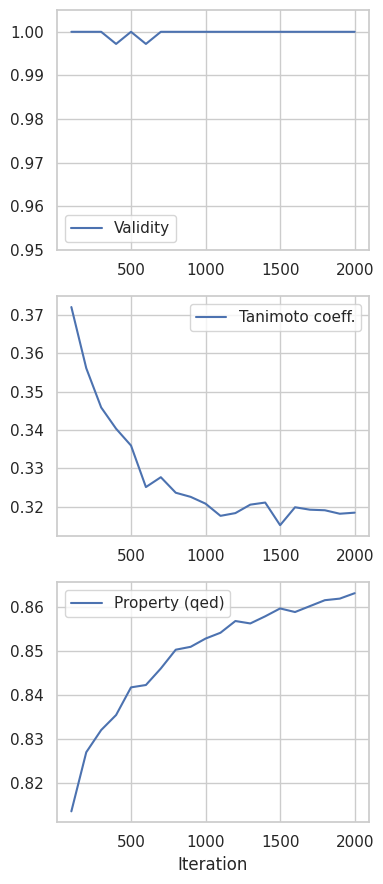

In [20]:
fig, axes = plt.subplots(3,1,figsize=(4,9))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()